# Machine Learning - Assignment 2

## Decision tree induction algorithm for classification tasks

The aim of the assignment is to:

* Implement a decision tree induction algorithm for classification tasks.
* Make sure it works for real valued features and nominal features (categorical features without rank, e.g., red - blue - green).
* Test the algorithm on 3 datasets.

Follow the instructions and implement what is missing to complete the assignment. Some functions have been started to help you a little bit with the inputs or outputs of the function.

**Note:** You might need to go back and forth during your implementation of the code. The structure is set up to make implementation easier, but how you return values from the different functions might vary, and you might find yourself going back and change something to make it easier later on.

## Assignment preparations

We help you out with importing the libraries.

**IMPORTANT NOTE:** You may not import any more libraries than the ones already imported!

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

## Decision tree model

The main objective is to implement the decision tree model. The implemented decision tree needs to be recursive model, that is, it should be implemented general enough to call itself in order to grow. "Growing" a tree refers to the same thing as "training" a model.

As said in the introduction, the structure is set up to help with implementation, but the nature of this model makes it a bit harder to implement function-by-function. You will most likely go back and forth between these first tasks.

### 1) Grow Tree

We will start with the main function of the decision tree, the "growing" function. 

This function should be called when creating the model, but also from inside itself. It is responible for creating all the nodes and leafs in the tree.

In [2]:
class TreeConfig:    
    def __init__(self, feature_types, feature_names, target_name, 
                 stopping_criteria, 
                 split_feature_fun,
                 max_depth=10, min_samples=2, homogeneity_threshold=0.9):
        self.feature_types = feature_types
        self.feature_names = feature_names
        self.target_name = target_name
        self.split_feature_fun = split_feature_fun
        
        self.max_depth = max_depth
        self.min_samples = min_samples
        self.homogeneity_threshold = homogeneity_threshold
        self.stopping_criteria = [] if stopping_criteria is None else stopping_criteria
    
    def should_stop(self, data, current_depth):
        for criterion in self.stopping_criteria:
            if criterion(data, current_depth, self):
                return True
        return False

In [3]:
def most_appropriate_label(data):
    label_values = np.unique(data)
    label_counts = np.zeros(len(label_values))
    for label in data:
        pos_idx = np.where(label_values == label)[0][0]
        label_counts[pos_idx] += 1
    label_counts /= len(data)
    return label_values[np.argmax(label_counts)], np.max(label_counts)

def grow_tree(data, feature_set, config, current_depth=0):    
    if config.should_stop(data, current_depth):
        return {"type": "leaf", "label": most_appropriate_label(data)[0]}
    
    best_feat_idx, split_value, split_type, subset_l_feats, subset_r_feats, subset_l_labels, subset_r_labels = split_data(data, feature_set, config)
    
    if split_value is None:
        return {"type": "leaf", "label": most_appropriate_label(data)[0]}
        
    node = {
        "type": "node",
        "feature": config.feature_names[best_feat_idx],
        "feature_index": best_feat_idx,
        "split_value": split_value,
        "split_type": split_type
    }
    
    node["left"] = grow_tree(subset_l_labels, subset_l_feats, config, current_depth + 1)    
    node["right"] = grow_tree(subset_r_labels, subset_r_feats, config, current_depth + 1)
    
    return node

### 2) Growth stopping conditions (or stopping criterias)

The "grow_tree" function needs some way of stop growing, otherwise it will grow indefinitely. We will adress this issue here.

The trees stopping criterias needs to handle the following:

1) When a node has only datapoints of a single class.

2) Prevent the tree from growing to large, i.e., a max depth.

3) Prevent the tree nodes from becoming to small.

4) Prevent the tree from growing when the node is large (has a lot of datapoints) but it is very unbalanced. This is an extention to case 1.

Can you think of some other stopping criterias that is good to have? 

In [4]:
def is_pure(data, current_depth, config):
    return len(np.unique(data)) == 1

def max_depth_reached(data, current_depth, config):
    return current_depth >= config.max_depth

def min_samples_reached(data, current_depth, config):
    return len(data) <= config.min_samples

def is_homogeneous(data, current_depth, config):
    label_values = np.unique(data)
    label_counts = np.zeros(len(label_values))
    for label in data:
        pos_idx = np.where(label_values == label)[0][0]
        label_counts[pos_idx] += 1
    label_counts /= len(data)
    max_proportion = np.max(label_counts)
    return max_proportion >= config.homogeneity_threshold

### 3) Best feature for splitting nodes

When we are growing the tree, we need to decide how we are going to split a node into two new nodes. This is achived by looking at the features of the data in the node and calculate the best feature to split on.

Here you have a choice:

* Split using **Information Entropy**
* Split using **Gini Impurity**

Finish the function below using Information Entropy or Gini Impurity.

**Note:** Your code should be able to handle both real and categorical features!

In [5]:
def calculate_probability(value, data):
    pb_value = np.where(data == value)[0].shape[0] / data.shape[0]
    return pb_value

def entropy(data):
    ent = 0
    
    for value in np.unique(data):
        pb = calculate_probability(value, data)
        if pb > 0:
            ent += pb * np.log(pb)
    ent = -ent
    
    return ent

def gini_index(data):
    gini = 1
    
    for value in np.unique(data):
        gini -= calculate_probability(value, data)**2
    
    return gini

def weighted_impurity(left_labels, right_labels, all_labels, split_feature_fun=entropy):
    n = all_labels.shape[0]
    n_l = left_labels.shape[0]
    n_r = right_labels.shape[0]
    
    if n_l == 0 or n_r == 0:
        return float('inf')
    return (n_l * split_feature_fun(left_labels) + n_r * split_feature_fun(right_labels)) / n

def extract_subsets_by_mask(data, feature_set, mask):
    left_idx = np.where(mask)[0]
    right_idx = np.where(~mask)[0]
    subset_l_feats = feature_set[left_idx]
    subset_r_feats = feature_set[right_idx]
    subset_l_labels = data[left_idx]
    subset_r_labels = data[right_idx]
    return subset_l_feats, subset_r_feats, subset_l_labels, subset_r_labels

def best_split_feature(data, feature_set, config):
    best_feat_idx = 0
    best_split_value = None
    best_split_type = "r"
    min_imp = float('inf')

    for i in range(feature_set.shape[1]):
        feature = feature_set[:, i]

        if config.feature_types[i] == "r":
            feat_float = feature.astype(float)
            mean_val = np.mean(feat_float)
            mask = feat_float < mean_val
            if mask.all() or (~mask).all():
                continue
            _, _, subset_l_labels, subset_r_labels = extract_subsets_by_mask(data, feature_set, mask)
            imp = weighted_impurity(subset_l_labels, subset_r_labels, data, config.split_feature_fun)
            if imp < min_imp:
                min_imp = imp
                best_feat_idx = i
                best_split_value = mean_val
                best_split_type = "r"

        else:
            unique_vals = np.unique(feature)
            for val in unique_vals:
                mask = (feature == val)
                if mask.all() or (~mask).all():
                    continue
                _, _, subset_l_labels, subset_r_labels = extract_subsets_by_mask(data, feature_set, mask)
                imp = weighted_impurity(subset_l_labels, subset_r_labels, data, config.split_feature_fun)
                if imp < min_imp:
                    min_imp = imp
                    best_feat_idx = i
                    best_split_value = val
                    best_split_type = "n"

    return best_feat_idx, best_split_value, best_split_type

### 4) Split data

When growing the tree, we need to split the data multiple times, and what we decide to split varies a lot. It is similar to splitting data into train and test sets (remember from assignment 1), but we split the data based on the best feature for growing a good tree.

**IMPORTANT NOTE:** To calculate binary splits for real-valued features, the following rule must be applied: an instance with a feature value lower than the mean feature value follows the left edge from the split node while all other instances follow the right edge from the split node.

In [6]:
def split_data(data, feature_set, config):
    best_feat_idx, split_value, split_type = best_split_feature(data, feature_set, config)
    
    if split_value is None:
        return best_feat_idx, None, None, None, None, None, None
    
    feature = feature_set[:, best_feat_idx]

    mask = feature.astype(float) < split_value if split_type == "r" else (feature == split_value)

    subset_l_feats, subset_r_feats, subset_l_labels, subset_r_labels = extract_subsets_by_mask(data, feature_set, mask)
    return best_feat_idx, split_value, split_type, subset_l_feats, subset_r_feats, subset_l_labels, subset_r_labels

### 5) Predict with tree model

Finally, when we have grown our tree, we would like to use it for prediction. When using the tree for prediction, we traverse the tree for each datapoint untill we land in a leaf node.

In [7]:
def predict_element(tree, test_element):
    if tree["type"] == "leaf":
        return tree["label"]
    
    feat_idx = tree["feature_index"]
    value = test_element[feat_idx]
    
    if tree["split_type"] == "r":
        if float(value) < float(tree["split_value"]):
            return predict_element(tree["left"], test_element)
        return predict_element(tree["right"], test_element)
    
    if str(value) == str(tree["split_value"]):
        return predict_element(tree["left"], test_element)
    return predict_element(tree["right"], test_element)

def predict_with_tree(tree, test_set):
    predicted_result = []
    for i in range(test_set.shape[0]):
        predicted_result.append(predict_element(tree, test_set[i]))
    return np.array(predicted_result)

## Test decision tree model, compare with scikit learn, and plot dataset results

In the last part of the lab, you are going to test your tree code and compare it to scikit learn. The goal is not to be better than an established library, but to give you an indication about if you are on the right track.

You will need to plot the results from your model and the scikit learn model using matplotlib. We suggest a simple but informative bar-charts.

To make the comparison fair, you should train and test both your decision tree algorithm and the scikit learn at least 5 times, and shuffle the data each time before splitting the data into a train and test set.

The datasets are:

* Wine - (https://archive.ics.uci.edu/dataset/109/wine)
* Heart disease - (https://archive.ics.uci.edu/dataset/45/heart+disease)
* Car - (https://archive.ics.uci.edu/dataset/19/car+evaluation)

**IMPORTANT NOTE 1:** Take note of the feature types in the datasets, some features are numerical in value but are in fact categorical features. Be sure to handle these features correctly!

**IMPORTANT NOTE 2:** In this assignment it helps to add an additional header with information about the features and if they are nominal (n) or real (r) features.

In [8]:
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.tree import DecisionTreeClassifier

You may use the "**accuracy_score**" function from scikit learn (imported above) to compare the performance of your own and scikit learns models.

See below for an example use.

In [9]:
y_true = [1,1,1,1,1] # Pretend labels
y_pred_entropy = [1,1,2,2,1] # Pretend prediction

accuracy_score(y_true, y_pred_entropy)

0.6

### 6) Dataset 1: Wine

Iteration 1: Our Model=0.8444, Scikit-Learn=0.8667
Iteration 2: Our Model=0.9778, Scikit-Learn=0.9333
Iteration 3: Our Model=0.9333, Scikit-Learn=0.9111
Iteration 4: Our Model=0.9778, Scikit-Learn=0.9556
Iteration 5: Our Model=0.9111, Scikit-Learn=0.9111


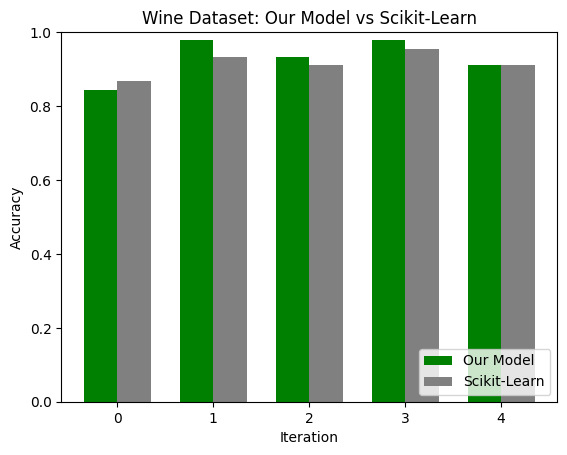

In [10]:
data_wine = pd.read_csv("wine.csv").to_numpy()

feature_types_wine = data_wine[0, 0:-1]
data_wine = data_wine[1:, :]

feature_names_wine = pd.read_csv("wine.csv", nrows=0).columns.to_numpy()[0:-1]
target_name_wine = pd.read_csv("wine.csv", nrows=0).columns.to_numpy()[-1]

config_wine = TreeConfig(feature_types_wine, feature_names_wine, target_name_wine,
                         stopping_criteria=[is_pure, max_depth_reached, min_samples_reached, is_homogeneous], 
                         split_feature_fun=entropy)

model_accuracies = []
scikit_accuracies = []

for i in range(5):
    X_train, X_test, y_train, y_test = train_test_split(
        data_wine[:, 0:-1], data_wine[:, -1], test_size=0.25, random_state=None)
    
    tree_entropy = grow_tree(y_train, X_train, config_wine)
    y_pred_entropy = predict_with_tree(tree_entropy, X_test)
    acc_entropy = accuracy_score(y_test, y_pred_entropy)
    
    tree_sk = DecisionTreeClassifier()
    tree_sk.fit(X_train.astype(float), y_train)
    y_pred_sk = tree_sk.predict(X_test.astype(float))
    acc_sk = accuracy_score(y_test, y_pred_sk)
    
    model_accuracies.append(acc_entropy)
    scikit_accuracies.append(acc_sk)
    print(f"Iteration {i+1}: Our Model={acc_entropy:.4f}, Scikit-Learn={acc_sk:.4f}")

fig, ax = plt.subplots()
x = np.arange(len(model_accuracies))
w = 0.35
ax.bar(x - w/2, model_accuracies, width=w, label="Our Model", color='green')
ax.bar(x + w/2, scikit_accuracies, width=w, label="Scikit-Learn", color='gray')
ax.set_ylim(0, 1)
ax.set_xlabel("Iteration")
ax.set_ylabel("Accuracy")
ax.set_title("Wine Dataset: Our Model vs Scikit-Learn")
ax.legend(loc='lower right')
plt.show()

### 7) Dataset 2: Heart Disease

Iteration 1: Our Model=0.9377, Scikit-Learn=1.0000
Iteration 2: Our Model=0.9416, Scikit-Learn=1.0000
Iteration 3: Our Model=0.9339, Scikit-Learn=1.0000
Iteration 4: Our Model=0.9105, Scikit-Learn=0.9883
Iteration 5: Our Model=0.9416, Scikit-Learn=1.0000


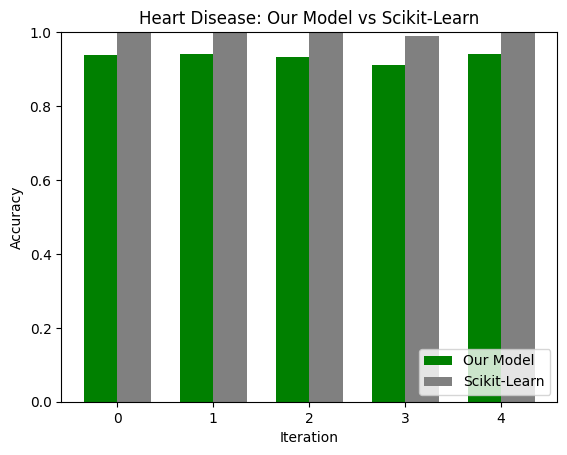

In [11]:
data_heart = pd.read_csv("heart.csv").to_numpy()

feature_names_heart = pd.read_csv("heart.csv", nrows=0).columns.to_numpy()[0:-1]
target_name_heart = pd.read_csv("heart.csv", nrows=0).columns.to_numpy()[-1]

feature_types_heart = np.array(["r","n","n","r","r","n","n","r","n","r","n","n","n"])

config_heart = TreeConfig(feature_types_heart, feature_names_heart, target_name_heart,
                         stopping_criteria=[is_pure, max_depth_reached, min_samples_reached, is_homogeneous], 
                         split_feature_fun=entropy)

model_accuracies_heart = []
scikit_accuracies_heart = []

for i in range(5):
    X_train, X_test, y_train, y_test = train_test_split(
        data_heart[:, 0:-1], data_heart[:, -1], test_size=0.25, random_state=None)
    
    tree_entropy = grow_tree(y_train, X_train, config_heart)
    y_pred_entropy = predict_with_tree(tree_entropy, X_test)
    acc_entropy = accuracy_score(y_test, y_pred_entropy)
    
    tree_sk = DecisionTreeClassifier()
    tree_sk.fit(X_train.astype(float), y_train)
    y_pred_sk = tree_sk.predict(X_test.astype(float))
    acc_sk = accuracy_score(y_test, y_pred_sk)
    
    model_accuracies_heart.append(acc_entropy)
    scikit_accuracies_heart.append(acc_sk)
    print(f"Iteration {i+1}: Our Model={acc_entropy:.4f}, Scikit-Learn={acc_sk:.4f}")

# Plot results
fig, ax = plt.subplots()
x = np.arange(len(model_accuracies_heart))
w = 0.35
ax.bar(x - w/2, model_accuracies_heart, width=w, label="Our Model", color='green')
ax.bar(x + w/2, scikit_accuracies_heart, width=w, label="Scikit-Learn", color='gray')
ax.set_ylim(0, 1)
ax.set_xlabel("Iteration")
ax.set_ylabel("Accuracy")
ax.set_title("Heart Disease: Our Model vs Scikit-Learn")
ax.legend(loc='lower right')
plt.show()

### 8) Dataset 3: Car

Iteration 1: Our Model=0.9468, Scikit-Learn=0.9769
Iteration 2: Our Model=0.9769, Scikit-Learn=0.9838
Iteration 3: Our Model=0.9676, Scikit-Learn=0.9838
Iteration 4: Our Model=0.9606, Scikit-Learn=0.9838
Iteration 5: Our Model=0.9606, Scikit-Learn=0.9722


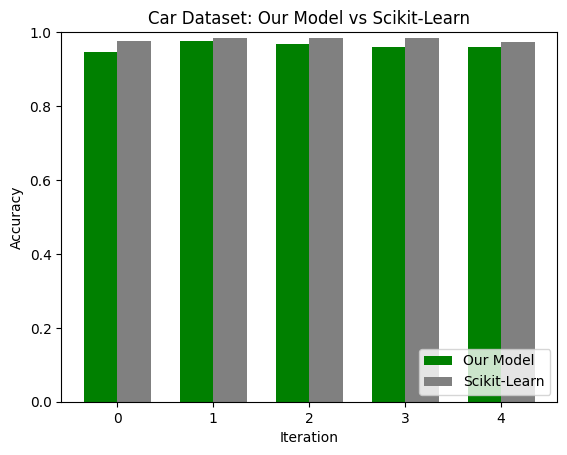

In [12]:
data = pd.read_csv("car.csv").to_numpy()

feature_names_all = pd.read_csv("car.csv", nrows=0).columns.to_numpy()
feature_names_all = np.array([name.strip() for name in feature_names_all])
feature_names = feature_names_all[0:-1]
target_name = feature_names_all[-1]

data = np.array([[val.strip() if isinstance(val, str) else val for val in row] for row in data])

feature_types_car = np.array(["n","n","n","n","n","n"])

config_entropy = TreeConfig(feature_types_car, feature_names, target_name,
                        stopping_criteria=[is_pure, max_depth_reached, min_samples_reached, is_homogeneous], 
                        split_feature_fun=entropy)

def encode_column(train_col, test_col):
    unique_vals = np.unique(np.concatenate([train_col, test_col]))
    mapping = {val: idx for idx, val in enumerate(unique_vals)}
    return (np.array([mapping[v] for v in train_col], dtype=float),
            np.array([mapping[v] for v in test_col], dtype=float))

model_accuracies_entropy = []
scikit_accuracies_car = []

for i in range(5):
    X_train, X_test, y_train, y_test = train_test_split(
        data[:, 0:-1], data[:, -1], test_size=0.25, random_state=None)
    
    tree_entropy = grow_tree(y_train, X_train, config_entropy)
    y_pred_entropy = predict_with_tree(tree_entropy, X_test)
    acc_entropy = accuracy_score(y_test, y_pred_entropy)
    
    X_train_encoded = np.zeros(X_train.shape, dtype=float)
    X_test_encoded = np.zeros(X_test.shape, dtype=float)
    for col in range(X_train.shape[1]):
        X_train_encoded[:, col], X_test_encoded[:, col] = encode_column(X_train[:, col], X_test[:, col])
    
    y_train_encoded, y_test_encoded = encode_column(y_train, y_test)
    
    tree_sk = DecisionTreeClassifier()
    tree_sk.fit(X_train_encoded, y_train_encoded)
    y_pred_encoded = tree_sk.predict(X_test_encoded)
    acc_sk = accuracy_score(y_test_encoded, y_pred_encoded)
    
    model_accuracies_entropy.append(acc_entropy)
    scikit_accuracies_car.append(acc_sk)
    print(f"Iteration {i+1}: Our Model={acc_entropy:.4f}, Scikit-Learn={acc_sk:.4f}")

fig, ax = plt.subplots()
x = np.arange(len(model_accuracies_entropy))
w = 0.35
ax.bar(x - w/2, model_accuracies_entropy, width=w, label="Our Model", color='green')
ax.bar(x + w/2, scikit_accuracies_car, width=w, label="Scikit-Learn", color='gray')
ax.set_ylim(0, 1)
ax.set_xlabel("Iteration")
ax.set_ylabel("Accuracy")
ax.set_title("Car Dataset: Our Model vs Scikit-Learn")
ax.legend(loc='lower right')
plt.show()

### 9) Training with normalized data on the wine-dataset

So far, we have trained our decision trees with "raw" data, i.e., we haven't done much preprocessing on the data.

Here we will do minor preprocessing on the data with the help of the scikit-learn library: https://scikit-learn.org/stable/modules/preprocessing.html

Iter 1: Raw Model=0.9333, Norm Model=0.9333, Raw SK=0.9556, Norm SK=0.9111
Iter 2: Raw Model=0.9111, Norm Model=0.9111, Raw SK=0.9778, Norm SK=0.9556
Iter 3: Raw Model=0.8444, Norm Model=0.8444, Raw SK=0.9111, Norm SK=0.9111
Iter 4: Raw Model=0.8222, Norm Model=0.8222, Raw SK=0.8444, Norm SK=0.8667
Iter 5: Raw Model=0.9778, Norm Model=0.9778, Raw SK=0.9111, Norm SK=0.9111


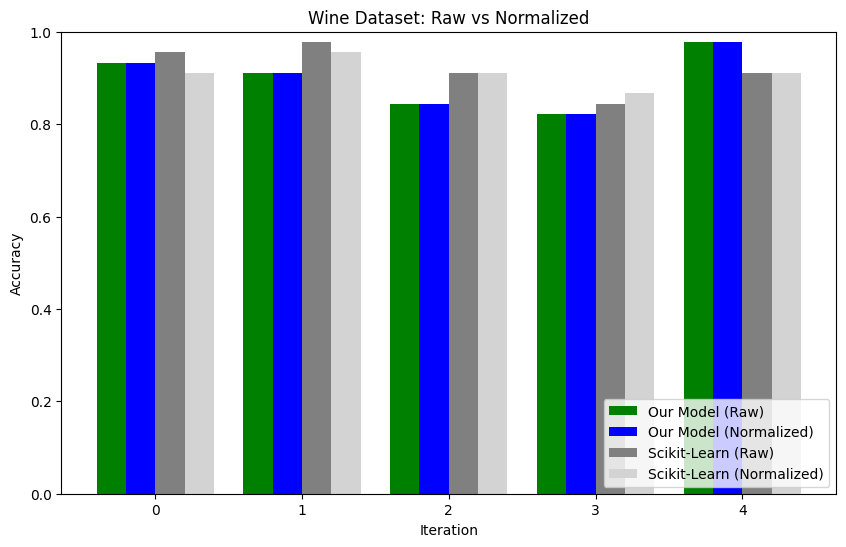

In [13]:
from sklearn import preprocessing

data_wine_raw = pd.read_csv("wine.csv").to_numpy()
feature_types_wine = data_wine_raw[0, 0:-1]
data_wine_raw = data_wine_raw[1:, :]

feature_names_wine = pd.read_csv("wine.csv", nrows=0).columns.to_numpy()[0:-1]
target_name_wine = pd.read_csv("wine.csv", nrows=0).columns.to_numpy()[-1]

config_wine = TreeConfig(feature_types_wine, feature_names_wine, target_name_wine,
                         stopping_criteria=[is_pure, max_depth_reached, min_samples_reached, is_homogeneous], 
                         split_feature_fun=entropy)

X_all = data_wine_raw[:, 0:-1].astype(float)
y_all = data_wine_raw[:, -1]

scaler = preprocessing.MinMaxScaler()
X_normalized = scaler.fit_transform(X_all)

model_acc_raw = []
model_acc_norm = []
scikit_acc_raw = []
scikit_acc_norm = []

for i in range(5):
    indices = np.arange(len(y_all))
    train_idx, test_idx = train_test_split(indices, test_size=0.25, random_state=None)
    
    X_train_raw = X_all[train_idx]
    X_test_raw = X_all[test_idx]
    X_train_norm = X_normalized[train_idx]
    X_test_norm = X_normalized[test_idx]
    y_train = y_all[train_idx]
    y_test = y_all[test_idx]
    
    X_train_raw_str = X_train_raw.astype(str)
    X_test_raw_str = X_test_raw.astype(str)
    X_train_norm_str = X_train_norm.astype(str)
    X_test_norm_str = X_test_norm.astype(str)
    
    tree_entropy = grow_tree(y_train, X_train_raw_str, config_wine)
    y_pred_entropy = predict_with_tree(tree_entropy, X_test_raw_str)
    acc_raw = accuracy_score(y_test, y_pred_entropy)
    
    tree_norm = grow_tree(y_train, X_train_norm_str, config_wine)
    y_pred_norm = predict_with_tree(tree_norm, X_test_norm_str)
    acc_norm = accuracy_score(y_test, y_pred_norm)
    
    tree_sk = DecisionTreeClassifier()
    tree_sk.fit(X_train_raw, y_train)
    acc_sk = accuracy_score(y_test, tree_sk.predict(X_test_raw))
    
    tree_norm_sk = DecisionTreeClassifier()
    tree_norm_sk.fit(X_train_norm, y_train)
    acc_norm_sk = accuracy_score(y_test, tree_norm_sk.predict(X_test_norm))
    
    model_acc_raw.append(acc_raw)
    model_acc_norm.append(acc_norm)
    scikit_acc_raw.append(acc_sk)
    scikit_acc_norm.append(acc_norm_sk)
    
    print(f"Iter {i+1}: Raw Model={acc_raw:.4f}, Norm Model={acc_norm:.4f}, "
          f"Raw SK={acc_sk:.4f}, Norm SK={acc_norm_sk:.4f}")

fig, ax = plt.subplots(figsize=(10, 6))
x = np.arange(5)
w = 0.2
ax.bar(x - 1.5*w, model_acc_raw, width=w, label="Our Model (Raw)", color='green')
ax.bar(x - 0.5*w, model_acc_norm, width=w, label="Our Model (Normalized)", color='blue')
ax.bar(x + 0.5*w, scikit_acc_raw, width=w, label="Scikit-Learn (Raw)", color='gray')
ax.bar(x + 1.5*w, scikit_acc_norm, width=w, label="Scikit-Learn (Normalized)", color='lightgray')
ax.set_ylim(0, 1)
ax.set_xlabel("Iteration")
ax.set_ylabel("Accuracy")
ax.set_title("Wine Dataset: Raw vs Normalized")
ax.legend(loc='lower right')
plt.show()

# Questions for examination:

In addition to completing the assignment with all its tasks, you should also prepare to answer the following questions:

1) Why is growing the tree indefinitely such a bad idea? The performance would increase would it not?

2) Beside preventing the tree from growing to large, what is the purpose of 'stopping criterias'?

3) What is the difference between **Information Entropy** and **Gini Impurity**?


[car.csv] Iteration 1: Entropy Model=0.9444, Gini Model=0.9444
[car.csv] Iteration 2: Entropy Model=0.9792, Gini Model=0.9745
[car.csv] Iteration 3: Entropy Model=0.9606, Gini Model=0.9583
[car.csv] Iteration 4: Entropy Model=0.9560, Gini Model=0.9537
[car.csv] Iteration 5: Entropy Model=0.9560, Gini Model=0.9537


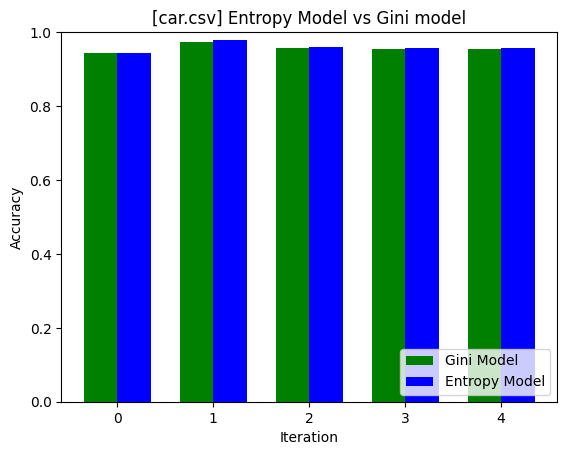

[heart.csv] Iteration 1: Entropy Model=0.9494, Gini Model=0.9377
[heart.csv] Iteration 2: Entropy Model=0.9105, Gini Model=0.9105
[heart.csv] Iteration 3: Entropy Model=0.9533, Gini Model=0.9455
[heart.csv] Iteration 4: Entropy Model=0.9377, Gini Model=0.9339
[heart.csv] Iteration 5: Entropy Model=0.9767, Gini Model=0.9611


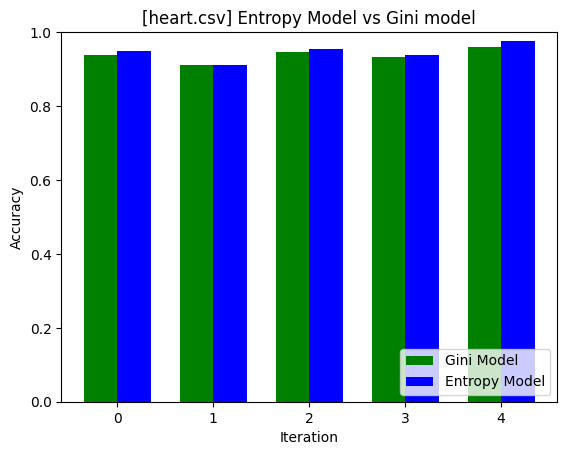

In [14]:
for file, feature_types in [("car.csv", ["n","n","n","n","n","n"]), ("heart.csv", ["r","n","n","r","r","n","n","r","n","r","n","n","n"])]:


    data = pd.read_csv(file).to_numpy()

    feature_names_all = pd.read_csv(file, nrows=0).columns.to_numpy()
    feature_names_all = np.array([name.strip() for name in feature_names_all])
    feature_names = feature_names_all[0:-1]
    target_name = feature_names_all[-1]

    data = np.array([[val.strip() if isinstance(val, str) else val for val in row] for row in data])

    feature_types_car = np.array(feature_types)

    config_entropy = TreeConfig(feature_types_car, feature_names, target_name,
                            stopping_criteria=[is_pure, max_depth_reached, min_samples_reached, is_homogeneous], 
                            split_feature_fun=entropy)

    config_gini = TreeConfig(feature_types_car, feature_names, target_name,
                            stopping_criteria=[is_pure, max_depth_reached, min_samples_reached, is_homogeneous], 
                            split_feature_fun=gini_index)

    model_accuracies_entropy = []
    model_accuracies_gini = []

    for i in range(5):
        X_train, X_test, y_train, y_test = train_test_split(
            data[:, 0:-1], data[:, -1], test_size=0.25, random_state=None)
        
        tree_entropy = grow_tree(y_train, X_train, config_entropy)
        y_pred_entropy = predict_with_tree(tree_entropy, X_test)
        acc_entropy = accuracy_score(y_test, y_pred_entropy)
        
        tree_gini = grow_tree(y_train, X_train, config_gini)
        y_pred_gini = predict_with_tree(tree_gini, X_test)
        acc_gini = accuracy_score(y_test, y_pred_gini)

        model_accuracies_entropy.append(acc_entropy)
        model_accuracies_gini.append(acc_gini)
        print(f"[{file}] Iteration {i+1}: Entropy Model={acc_entropy:.4f}, Gini Model={acc_gini:.4f}")

    fig, ax = plt.subplots()
    x = np.arange(len(model_accuracies_entropy))
    w = 0.35
    ax.bar(x - w/2, model_accuracies_gini, width=w, label="Gini Model", color='green')
    ax.bar(x + w/2, model_accuracies_entropy, width=w, label="Entropy Model", color='blue')
    ax.set_ylim(0, 1)
    ax.set_xlabel("Iteration")
    ax.set_ylabel("Accuracy")
    ax.set_title(f"[{file}] Entropy Model vs Gini model")
    ax.legend(loc='lower right')
    plt.show()


4) What are some pros about using decision trees?

5) Did preprocessing the data help with performance when using decision trees?

# Finished!

Was part of the setup incorrect? Did you spot any inconsistencies in the assignment? Could something improve?

If so, please write them and send via email and send it to:

* marcus.gullstrand@ju.se

Thank you!